# Classificação por Floresta Aleatória (Random Forest)

A classificação por floresta aleatória é uma técnica de aprendizado de máquina que combina o poder da aleatoriedade com o poder da média para construir um modelo robusto de classificação. Ela opera criando múltiplas árvores de decisão durante o treinamento e fazendo previsões com base na maioria das previsões das árvores individuais.

## Principais Características:
- **Árvores de Decisão:** Cada árvore na floresta é construída a partir de uma amostra aleatória do conjunto de dados de treinamento. Isso ajuda a reduzir a correlação entre as árvores individuais, tornando o modelo mais robusto.

- **Amostragem Aleatória de Características:** Durante a construção de cada árvore, apenas um subconjunto aleatório das características é considerado para dividir em cada nó da árvore. Isso introduz mais diversidade nas árvores e reduz a probabilidade de overfitting.

- **Votação por Maioria:** Ao fazer previsões, cada árvore na floresta contribui com uma votação para determinar a classe final de um exemplo. A classe mais frequente entre todas as árvores é escolhida como a previsão final.

## Vantagens:
- **Robustez:** Averiguando várias árvores de decisão, o modelo é menos propenso a overfitting e tem uma melhor capacidade de generalização em dados de teste.

- **Manuseio de Dados Não Lineares e de Alta Dimensão:** Pode lidar eficazmente com conjuntos de dados com muitas características e interações complexas entre elas.

- **Fácil de Usar:** Requer pouca ou nenhuma sintonia de parâmetros e lida bem com dados ausentes.

## Limitações:
- **Interpretabilidade:** Às vezes, a floresta aleatória pode ser difícil de interpretar em comparação com modelos lineares simples.

- **Desempenho em Dados Escaláveis:** Para conjuntos de dados muito grandes, o treinamento de uma floresta aleatória pode se tornar computacionalmente caro.

## Aplicações:
- **Classificação:** Prever a classe de um exemplo com base em suas características.

A implementação da classificação por floresta aleatória no scikit-learn, utilizando RandomForestClassifier, oferece uma interface simples e poderosa para treinar e fazer previsões com este modelo.

Importando bibliotecas

In [1]:
import gsidiag as gd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score


from itertools import combinations
from itertools import cycle
import seaborn as sns



Definindo parâmetros para o uso do readDiag

In [3]:
DIRdiag = "/home/patrick/readDiag/data"

varName = "amsua"
varType = "n15"
dateIni="2020010100" 
dateFin="2020010106" 
nHour = "6"          
vminOMA = -2.0       
vmaxOMA = 2.0        
vminSTD = 0.0        
vmaxSTD = 14.0       
Level = 1000
Lay = None           
SingleL = "All" 

datei = datetime.strptime(str(dateIni), "%Y%m%d%H")
datef = datetime.strptime(str(dateFin), "%Y%m%d%H")
dates = [dates.strftime('%Y%m%d%H') for dates in pd.date_range(datei, datef,freq="6H").tolist()]

print(dates)


['2020010100', '2020010106']


Encontrando e listando arquivos para serem usados

In [4]:
paths, pathsc = [], []

OuterL = "01"        
[paths.append(DIRdiag+"/"+dt+"/diag_amsua_n15_"+OuterL+"."+dt) for dt in dates]

OuterLc = "03"
[pathsc.append(DIRdiag+"/"+dt+"/diag_amsua_n15_"+OuterLc+"."+dt) for dt in dates]

print(paths)
print("")
print(pathsc)

['/home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100', '/home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106']

['/home/patrick/readDiag/data/2020010100/diag_amsua_n15_03.2020010100', '/home/patrick/readDiag/data/2020010106/diag_amsua_n15_03.2020010106']


Definição da função para discretizar os dados de impacto:

In [5]:
# Função que retorna a categoria:
def categoria_de(valorRF):
    categoria = None
    if valorRF <= -0.25:
        categoria = "Impacto negativo alto"
    elif valorRF > -0.25 and valorRF < 0:
        categoria = "Impacto negativo baixo"
    elif valorRF == 0:
        categoria = "Impacto neutro"
    elif valorRF > 0 and valorRF < 0.25:
        categoria = "Impacto positivo baixo"
    elif valorRF >= 0.25:
        categoria = "Impacto positivo alto"
    return categoria

In [6]:
def MatrizConfusao(YTEST, YPRED, CLASSES, TIPO):
    # Computa a matriz de confusão
    matriz_confusao = confusion_matrix(YTEST, YPRED)

    # Imprime a matriz de confusão
    print(f"Matriz de Confusão para {TIPO}:")
    print(matriz_confusao)

    # Calcula a soma de cada linha da matriz de confusão
    sum_by_class = np.sum(matriz_confusao, axis=1)

    # Normaliza a matriz de confusão
    matriz_confusao_normalized = matriz_confusao / sum_by_class[:, np.newaxis]

    # Plota a matriz de confusão normalizada
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusao_normalized, annot=True, fmt=".3f", 
                cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f"Matriz de Confusão - {TIPO}")
    plt.xlabel("Valor Previsto")
    plt.ylabel("Valor Real")
    plt.savefig(f"MatrizConfusao_{TIPO}.png", facecolor='white')
    plt.show()
    
    print("Função MatrizConfusao concluída!")

In [7]:
def FeatureImportance(MODELO, ATRIBUTOS, TIPO):
    # Computa a importância dos atributos usando o método de diminuição da impureza (MDI)
    importances = MODELO.feature_importances_
    std = np.std([tree.feature_importances_ for tree in MODELO.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=ATRIBUTOS)

    # Plota a importância dos atributos
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(f"Importâncias dos recursos usando MDI - {TIPO}")
    ax.set_ylabel("Diminuição média na impureza")
    fig.tight_layout()
    plt.savefig(f"FeatureImportance_{TIPO}.png", facecolor='white')
    plt.show()
    
    print("Função FeatureImportance concluída!")

In [8]:
def train_test_pred_score_RFC(XIS, YPSILOM):
    # Divisão dos dados em conjuntos de treinamento e teste    
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(XIS, YPSILOM, test_size=0.2, random_state=42)
    print('Treino e Teste prontos')
    print(separator)

    # Inicialização e treinamento do modelo RandomForestClassifier
    MODELO = RandomForestClassifier(n_estimators=100, random_state=42)
    MODELO.fit(X_TRAIN, Y_TRAIN)
    print('Modelo treinado!')
    print(separator)

    # Faz previsões usando o modelo treinado nos dados de teste
    Y_PRED = MODELO.predict(X_TEST)
    print('Previsões feitas!')
    print(separator)

    # Faz previsões de probabilidade usando o modelo treinado nos dados de teste
    Y_SCORE = MODELO.predict_proba(X_TEST)
    print('Previsões de probabilidade feitas!')
    print(separator)
    
    print("Função train_test_pred_score_RFC concluída!")
    
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST, MODELO, Y_PRED, Y_SCORE

Lendo arquivos listado usando o readDiag e concatenando os dados

In [9]:
# Define uma variável booleana 'read' como True para indicar que a leitura dos arquivos será realizada
read = True

# Verifica se 'read' é True para prosseguir com a leitura dos arquivos
if read:        
    # Inicializa uma lista vazia para armazenar os objetos gdf
    gdf_list = []
    # Imprime uma mensagem informando o tempo estimado necessário para a leitura dos arquivos
    print("")
    print("Aguarde, o tempo total estimado para a leitura dos arquivos é de "+
          str(int((float(len(paths))*20 )/60))+" minutos e "+
          str(int((float(len(paths))*20 )%60))+" segundos.")
    print("")
    # Itera sobre os caminhos dos arquivos e seus caminhos de configuração correspondentes
    for path, pathc in zip(paths,pathsc):
        # Imprime uma mensagem indicando o arquivo que está sendo lido
        print("Reading "+path)
        # Lê o arquivo usando a função read_diag do módulo gsidiag e armazena o objeto retornado em gdf
        gdf = gd.read_diag(path,pathc)
        # Adiciona o objeto gdf à lista gdf_list
        gdf_list.append(gdf)

    # Imprime a lista de objetos gdf lidos
    print(gdf_list)
    
    # Define uma string separadora para uso posterior
    separator = " ====================================================================================================="



Aguarde, o tempo total estimado para a leitura dos arquivos é de 0 minutos e 40 segundos.

Reading /home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100
 
>>> GSI DIAG <<<
 
Reading /home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106
 
>>> GSI DIAG <<<
 
[<gsidiag.__main__.read_diag object at 0x7fbdb0db4bd0>, <gsidiag.__main__.read_diag object at 0x7fbdb0db3650>]


In [10]:
# Inicialização de DataFrame vazio para armazenar dados concatenados
df_concatenado2 = pd.DataFrame()

# Iteração sobre objetos em gdf_list
for objeto in gdf_list:
        
    print(separator)
    print("Separando dados do arquivo" + str(objeto._diagFile))
    
    # Criação de dicionário de dados a partir do objeto   
    dados_dict = {
            'lat': objeto.obsInfo[varName].loc[varType].lat,
            'lon': objeto.obsInfo[varName].loc[varType].lon,
            'elev': objeto.obsInfo[varName].loc[varType].elev,
            'nchan': objeto.obsInfo[varName].loc[varType].nchan,
            'time': objeto.obsInfo[varName].loc[varType].time,
            'iuse': objeto.obsInfo[varName].loc[varType].iuse,
            'idqc': objeto.obsInfo[varName].loc[varType].idqc,
            'inverr': objeto.obsInfo[varName].loc[varType].inverr,
            'oer': objeto.obsInfo[varName].loc[varType].oer,
            'obs': objeto.obsInfo[varName].loc[varType].obs,
            'omf': objeto.obsInfo[varName].loc[varType].omf,
            'omf_nobc': objeto.obsInfo[varName].loc[varType].omf_nobc,
            'emiss': objeto.obsInfo[varName].loc[varType].emiss,
            'oma': objeto.obsInfo[varName].loc[varType].oma,
            'oma_nobc': objeto.obsInfo[varName].loc[varType].oma_nobc,
            'imp': objeto.obsInfo[varName].loc[varType].imp,
            'dfs': objeto.obsInfo[varName].loc[varType].dfs
            }
        
    # Conversão do dicionário em DataFrame
    df_objeto = pd.DataFrame(dados_dict)
    
    # Aplicação da função 'categoria_de' para criar a coluna 'imp_categ'
    df_objeto['imp_categ'] = df_objeto['imp'].apply(categoria_de)
        
    # Concatenação do DataFrame do objeto com o DataFrame concatenado
    df_concatenado2 = pd.concat([df_concatenado2, df_objeto], ignore_index=True)
    

Separando dados do arquivo/home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100
Separando dados do arquivo/home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106


In [11]:
# Remoção de linhas com valores NaN
df_concatenado2.dropna(inplace=True)

# Filtrando os canais sub-representados
df_concatenado2 = df_concatenado2[~df_concatenado2['nchan'].isin([1, 2, 3, 4, 5, 15])]

print(df_concatenado2)

print(separator)
    
# Lista de atributos a serem usados para treinamento
#atributos = ['omf', 'oma', 'dfs', 'imp']
atributos = ['lat','lon','elev','time',
             'idqc','obs','omf','omf_nobc',
             'emiss','oma','oma_nobc','imp','dfs']


# Define as classes do target discretizado para uso posterior
classes = ['6','7','8','9','10','12','13']

X = df_concatenado2[atributos]
y = df_concatenado2['nchan']

              lat         lon         elev  nchan      time  iuse  idqc  \
5      -87.504501   19.704599  2735.045410    6.0  0.315833  -1.0  -0.0   
6      -87.504501   19.704599  2735.045410    7.0  0.315833   1.0   0.0   
7      -87.504501   19.704599  2735.045410    8.0  0.315833   1.0   0.0   
8      -87.504501   19.704599  2735.045410    9.0  0.315833   1.0   0.0   
9      -87.504501   19.704599  2735.045410   10.0  0.315833   1.0   0.0   
...           ...         ...          ...    ...       ...   ...   ...   
209947  77.502502  358.795105    -0.108379    8.0  1.952778   1.0   0.0   
209948  77.502502  358.795105    -0.108379    9.0  1.952778   1.0   0.0   
209949  77.502502  358.795105    -0.108379   10.0  1.952778   1.0   0.0   
209951  77.502502  358.795105    -0.108379   12.0  1.952778   1.0   0.0   
209952  77.502502  358.795105    -0.108379   13.0  1.952778   1.0   0.0   

          inverr       oer         obs       omf  omf_nobc     emiss  \
5       3.557238  0.281441 

In [12]:
# Supondo que você tenha um DataFrame chamado df com as colunas 'lat', 'lon', 'nchan' e 'imp'

# Crie uma coluna 'linha' que combina 'lat' e 'lon' para representar a linha
df_concatenado2['linha'] = df_concatenado2['lat'].astype(str) + '_' + df_concatenado2['lon'].astype(str)

# Use pivot_table() para pivotar os dados
df_pivot = df_concatenado2.pivot_table(index=('lat', 'lon'), columns='nchan', values=('imp', 'dfs'), aggfunc='sum')

# Resetando o índice para manter 'linha' como uma coluna
df_pivot.reset_index(inplace=False)

# Remoção de linhas com valores NaN
df_pivot.dropna(inplace=True)

# Lista de colunas que contêm os valores de DFS para cada canal
cols_dfs = [('dfs', 6.0), ('dfs', 7.0), ('dfs', 8.0), ('dfs', 9.0), ('dfs', 10.0), ('dfs', 12.0), ('dfs', 13.0)]

# Encontrar o canal com o maior valor de DFS em cada linha
df_pivot['canal_maior_dfs'] = df_pivot[cols_dfs].idxmax(axis=1).str[1]

# Lista de colunas que contêm os valores de imp para cada canal
cols_imp = [('imp', 6.0), ('imp', 7.0), ('imp', 8.0), ('imp', 9.0), ('imp', 10.0), ('imp', 12.0), ('imp', 13.0)]

# Encontrar o canal com o maior valor de imp em cada linha
df_pivot['canal_maior_imp'] = df_pivot[cols_imp].idxmax(axis=1).str[1]

print(df_pivot)

                            dfs                                          \
nchan                       6.0       7.0       8.0       9.0      10.0   
lat        lon                                                            
-87.523804 298.361603  0.031081 -0.039069  0.027618 -0.034395 -0.001559   
-87.504501 19.704599  -0.007727  0.006990 -0.001525  0.002950 -0.013614   
-87.493202 254.576904  0.034968  0.013145 -0.002379  0.025087  0.018040   
-87.491898 46.805698   0.005527 -0.001519 -0.020106 -0.006633  0.000301   
-87.463799 233.130493  0.007995 -0.041775  0.002829 -0.013485  0.047977   
...                         ...       ...       ...       ...       ...   
 85.345001 222.644104 -0.048653  0.007321 -0.046471  0.003466  0.022113   
 85.428299 156.027206 -0.112358 -0.000126 -0.085742 -0.059733  0.007503   
 85.456100 170.557098 -0.089187 -0.006383 -0.058945 -0.045503  0.040091   
 86.317101 55.701302  -0.717002 -0.137893  0.083512 -0.055097  0.000040   
 86.592300 78.411201  -0.

In [13]:
print(df_pivot.columns)


MultiIndex([(            'dfs',  6.0),
            (            'dfs',  7.0),
            (            'dfs',  8.0),
            (            'dfs',  9.0),
            (            'dfs', 10.0),
            (            'dfs', 12.0),
            (            'dfs', 13.0),
            (            'imp',  6.0),
            (            'imp',  7.0),
            (            'imp',  8.0),
            (            'imp',  9.0),
            (            'imp', 10.0),
            (            'imp', 12.0),
            (            'imp', 13.0),
            ('canal_maior_dfs',   ''),
            ('canal_maior_imp',   '')],
           names=[None, 'nchan'])


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. Preparação dos Dados
X = df_pivot[['imp', 'dfs']]
y = df_pivot[['canal_maior_dfs', 'canal_maior_imp']]

# 2. Divisão dos Dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Escolha e Treinamento do Modelo
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Calculate predictions on the test set
y_pred = model.predict(X_test)

print(y_test)

# y_test dataframe
y_test_dfs = pd.Series(y_test.iloc[:, 0])
y_test_imp = pd.Series(y_test.iloc[:, 1])

# Convertendo o array numpy em uma série pandas
y_pred_series1 = pd.Series(y_pred[:, 0])  # Supondo que você queira contar as repetições do primeiro elemento de cada linha
y_pred_series2 = pd.Series(y_pred[:, 1])

# Contando as repetições e imprimindo a ordem
repeticoes1 = y_pred_series1.value_counts()
repeticoes2 = y_pred_series2.value_counts()

# Visualize the channels classified based on the predictions
print("Channels classified based on predictions for 'dfs':")
print(repeticoes1)

print("\nChannels classified based on predictions for 'imp':")
print(repeticoes2)


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


                      canal_maior_dfs canal_maior_imp
nchan                                                
lat        lon                                       
-13.671600 106.723602            13.0             8.0
 62.156399 148.146606             6.0             6.0
 4.521300  34.552502              6.0             6.0
-20.413200 236.334702             6.0             9.0
-17.650000 74.559998              6.0             6.0
...                               ...             ...
-26.866600 342.559906            13.0            13.0
-51.679199 15.758300              6.0             6.0
-22.743401 47.199501             13.0            13.0
 50.270401 348.662689             9.0             9.0
-0.593500  221.126999            10.0             6.0

[2301 rows x 2 columns]
Channels classified based on predictions for 'dfs':
6.0     580
10.0    325
7.0     309
12.0    295
13.0    290
9.0     280
8.0     222
dtype: int64

Channels classified based on predictions for 'imp':
6.0     488
13.0 

/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


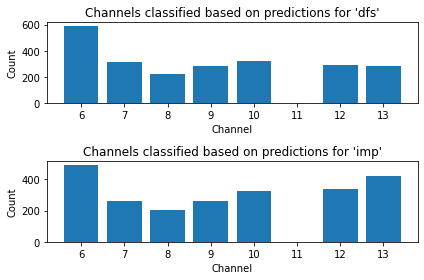

In [15]:
import matplotlib.pyplot as plt

# Dados para 'dfs'
channels_dfs = {
    6.0:     587,
    10.0:    321,
    7.0:     311,
    12.0:    293,
    13.0:    286,
    9.0:     280,
    8.0:     223
}

# Dados para 'imp' (supondo que sejam os mesmos)
channels_imp = {
    6.0:     492,
    13.0:    423,
    12.0:    337,
    10.0:    323,
    9.0:     262,
    7.0:     259,
    8.0:     205,
}

# Criando as figuras e os eixos
fig, axs = plt.subplots(2)

# Plotando os dados para 'dfs'
axs[0].bar(channels_dfs.keys(), channels_dfs.values())
axs[0].set_title("Channels classified based on predictions for 'dfs'")
axs[0].set_xlabel("Channel")
axs[0].set_ylabel("Count")

# Plotando os dados para 'imp'
axs[1].bar(channels_imp.keys(), channels_imp.values())
axs[1].set_title("Channels classified based on predictions for 'imp'")
axs[1].set_xlabel("Channel")
axs[1].set_ylabel("Count")

# Ajustando o layout
plt.tight_layout()

# Exibindo o gráfico
plt.show()

Matriz de Confusão para:
[[529   4   2   8   6   6   1]
 [ 12 283   2   2   5   4   3]
 [  7   5 206   5   6   5   3]
 [  7   4   4 255   6   5   2]
 [ 12   5   7   3 293   1   2]
 [  7   4   0   5   6 271   2]
 [  6   4   1   2   3   3 277]]


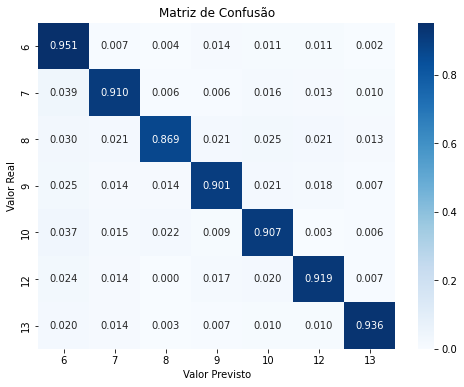

Função MatrizConfusao concluída!
Matriz de Confusão para:
[[458   1   2   0   4   5  13]
 [  4 247   2   3   3  11   5]
 [  6   4 183   2   5   4   8]
 [  6   1   5 252   6   6   8]
 [  5   3   7   2 298   3   5]
 [  5   4   4   2   1 307   9]
 [  4   1   1   2   1   2 381]]


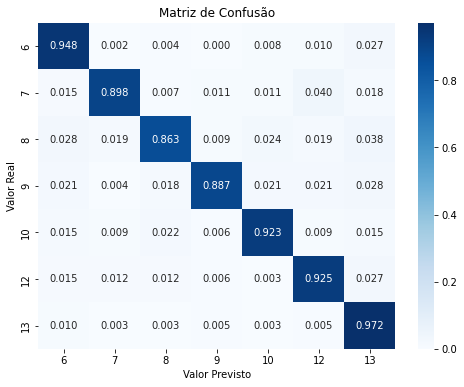

Função MatrizConfusao concluída!


In [18]:
def MatrizConfusao(YTEST, YPRED, CLASSES):
    # Computa a matriz de confusão
    matriz_confusao = confusion_matrix(YTEST, YPRED)

    # Imprime a matriz de confusão
    print(f"Matriz de Confusão para:")
    print(matriz_confusao)

    # Calcula a soma de cada linha da matriz de confusão
    sum_by_class = np.sum(matriz_confusao, axis=1)

    # Normaliza a matriz de confusão
    matriz_confusao_normalized = matriz_confusao / sum_by_class[:, np.newaxis]

    # Plota a matriz de confusão normalizada
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusao_normalized, annot=True, fmt=".3f", 
                cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f"Matriz de Confusão")
    plt.xlabel("Valor Previsto")
    plt.ylabel("Valor Real")
    plt.savefig(f"MatrizConfusao.png", facecolor='white')
    plt.show()
    
    print("Função MatrizConfusao concluída!")
    
classes = ['6','7','8','9','10','12','13']
MatrizConfusao(y_test.iloc[:, 0], y_pred_series1, classes)
MatrizConfusao(y_test.iloc[:, 1], y_pred_series2, classes)

In [17]:
# Gera e imprime o relatório de classificação, que inclui métricas como precisão, recall e F1-score
relatorio_classificacao = classification_report(y_test.iloc[:, 0], y_pred_series1)
print("\nRelatório de Classificação DFS:")
print(relatorio_classificacao)

# Gera e imprime o relatório de classificação, que inclui métricas como precisão, recall e F1-score
relatorio_classificacao = classification_report(y_test.iloc[:, 1], y_pred_series2)
print("\nRelatório de Classificação IMP:")
print(relatorio_classificacao)



Relatório de Classificação DFS:
              precision    recall  f1-score   support

         6.0       0.91      0.95      0.93       556
         7.0       0.92      0.91      0.91       311
         8.0       0.93      0.87      0.90       237
         9.0       0.91      0.90      0.91       283
        10.0       0.90      0.91      0.90       323
        12.0       0.92      0.92      0.92       295
        13.0       0.96      0.94      0.95       296

    accuracy                           0.92      2301
   macro avg       0.92      0.91      0.92      2301
weighted avg       0.92      0.92      0.92      2301


Relatório de Classificação IMP:
              precision    recall  f1-score   support

         6.0       0.94      0.95      0.94       483
         7.0       0.95      0.90      0.92       275
         8.0       0.90      0.86      0.88       212
         9.0       0.96      0.89      0.92       284
        10.0       0.94      0.92      0.93       323
        12.0